<a href="https://colab.research.google.com/github/ErikValle/Data-Augmentation-for-YOLOv5/blob/main/Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation for YOLOv5
This approach uses Data Augmentation to generate new samples given a training/validation dataset without the Keras Augmentation.

### Prerequisites
They are the same as YOLOv5, but make sure you have already installed them.

In [1]:
!git clone https://github.com/ErikValle/Data-Augmentation-for-YOLOv5.git
%cd Data-Augmentation-for-YOLOv5/
%ls

Cloning into 'Data-Augmentation-for-YOLOv5'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 64 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/Data-Augmentation-for-YOLOv5
Augmentation.ipynb  LICENSE  README.md  requirements.txt  samples/


In [2]:
%pip install -qr requirements.txt  # install dependencies

     |████████████████████████████████| 596 kB 5.4 MB/s 


In [3]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%config InlineBackend.figure_format='retina'
import os
import shutil
from skimage.util import random_noise
np.random.seed(42) ## random seed, change it accordingly
import tensorflow_hub as hub
import tensorflow as tf

## 1. Convert to YOLO format

### **Recall:** YOLOv5 requires the dataset to be in the darknet format. Here’s an outline of what it looks like:
- One txt with labels file per image
- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide `x_center` and `width` by image width, and `y_center` and `height` by image height.
- Class numbers are zero-indexed (start from 0).

**Example**:
- Image properties: width=1156 pix, height=1144 pix.
- bounding box properties: xmin=1032, ymin=20, xmax=1122, ymax=54, object_name="Ring".
- Let objects_list="bracelet","Earring","Ring","Necklace"

**YOLOv5 format:** f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
- $bbox_{width} = x_{max}/width - x_{min}/width = (1122-1032)/1156 = 0.07785467128027679$
- $bbox_{height} = y_{max}/height - y_{min}/height = (54-20)/1144 = 0.029720279720279717$ 
- $x_{center}=x_{min}/width+bbox_{width}/2 = 0.9316608996539792$
- $y_{center}=y_{min}/height + bbox_{height}/2 = 0.032342657342657344$
- category_idx=2
- Final result: **2 0.9316608996539792 0.032342657342657344 0.07785467128027679 0.029720279720279717**

In [4]:
def read_files(img_dir, lbl_dir):
  lbls_dataset = []
  images = os.listdir(img_dir)
  img_names = []
  for i, image_name in enumerate(tqdm(images)): #Load images and labels from source
    img_names.append(image_name)
    with open(lbl_dir+'/'+image_name.split('.')[0]+'.txt') as f:
        lbls_dataset.append(f.readlines())
        lbls_dataset[i][0]=lbls_dataset[i][0].replace('\n', '').split(' ') #remove unwanted characters and split data
  return lbls_dataset, img_names

### Data Reading and Storage Functions

In [5]:
def find_data(labels_dataset, typ):
    """
    Description: Find files with the given category.
    labels_dataset = list
    typ = int, numberic value of the desired category to be found 
    """
    index=[]
    for d in range(len(labels_dataset)):
        if int(labels_dataset[d][0][0])==typ:
            index.append(d)
    if len(index) == 0:
        print('The dataset does not contain any requested label')
    return index
def xml2dim(labels_dataset):
    """
    Description: Clean and organize the given labels_dataset
    labels_dataset = list
    """
    lbl=labels_dataset[0][0] #category
    a=float(labels_dataset[0][1]) #box center X
    b=float(labels_dataset[0][2]) #box center Y
    bbox_width=float(labels_dataset[0][3]) #box width
    bbox_height=float(labels_dataset[0][4]) #box height
    return lbl, a, b, bbox_width, bbox_height
def create_imgnlbl(name, lbl, img, x1, x2, y1, y2):
    """
    Description: Save augmented image and label in a pre-defined directory
    name=file name without extension (str)
    lbl = category number(int)
    img= MxN list
    x1, x2, y1, y2 = coordinates of bbox
    Note: Modify the label and image directories accordingly
    """
    labels_path = Path(f"{labels_directory}")#labels path
    h,w,_=img.shape
    x1, y1 = x1/w, y1/h #escalate x and y (0 to 1)
    x2, y2 = x2/w, y2/h
    bbox_width = x2 - x1
    bbox_height = y2 - y1
    cv2.imwrite(image_directory+"/"+name+'.jpg', img)
    name_l=name+".txt"
    with (labels_path/name_l).open(mode="w") as label_file:
        label_file.write(
            f"{lbl} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
        )
    return
def create_lblbox(img, lbl, x1, x2, y1, y2):
    """
    Description: Create a label in the YOLOv5 format
    lbl = category number(int)
    x1, x2, y1, y2 = coordinates of bbox
    Note: Modify the label and image directories accordingly
    """
    h,w,_=img.shape
    x1, y1 = x1/w, y1/h #escalate x and y (0 to 1)
    x2, y2 = x2/w, y2/h
    bbox_width = x2 - x1
    bbox_height = y2 - y1
    return [[float(lbl), float(x1 + bbox_width / 2), float(y1 + bbox_height / 2), float(bbox_width), float(bbox_height)]]

### Photometric Transformations

In [ ]:
#The following lines are just for your reference, uncomment them and paste them in sectin "Generating samples with TTA" as required
"""
img_gnoise = (255*random_noise(img, mode='gaussian', var=0.05**2)).astype(np.uint8) #_GN
img_lnoise = (255*random_noise(img, mode='localvar')).astype(np.uint8) #_LN
img_psnoise = (255*random_noise(img, mode='poisson')).astype(np.uint8) #_PN
img_snoise = (255*random_noise(img, mode='salt', amount=0.05)).astype(np.uint8) #_SN
img_ppnoise = (255*random_noise(img, mode='pepper', amount=0.05)).astype(np.uint8) #_PP
img_spnoise = (255*random_noise(img, mode='s&p', amount=0.05, salt_vs_pepper=0.5)).astype(np.uint8) #_SP
img_spknoise = (255*random_noise(img, mode='speckle')).astype(np.uint8) #_SE
img_gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR) #_GR
img_HE = cv2.cvtColor(cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)),cv2.COLOR_GRAY2BGR) #_HE
"""

### Geometric Transformations

In [6]:
def shear(img,labels_dataset,shx,shy):
    """
    Description: Shear transformation and its corresponding bounding box coordinates
    img= MxN list
    labels_dataset = list
    shx, shy = float
    """
    M = np.float32([[1, shx, 0],[shy, 1  , 0],[0, 0  , 1]])
    sheared_img = cv2.warpPerspective(img,M,(int(img.shape[1]*(1+shx)),int(img.shape[0]*(1+shy))))
    _,a,b,bbox_width,bbox_height=xml2dim(labels_dataset)
    h,w,_=img.shape
    x1, y1 = np.round_((a-bbox_width/2)*w,0), np.round_((b-bbox_height/2)*h,0)
    x2, y2 = np.round_((a+bbox_width/2)*w,0), np.round_((b+bbox_height/2)*h,0)
    #Affine Transformation
    u1, u2=int(M[0][0]*x1+M[0][1]*y1+M[0][2]), int(M[0][0]*x2+M[0][1]*y2+M[0][2])
    v1, v2=int(M[1][0]*x1+M[1][1]*y1+M[1][2]), int(M[1][0]*x2+M[1][1]*y2+M[1][2])
    return sheared_img, u1, u2, v1, v2
def flip(img,labels_dataset,mode):
    """
    Description: Flip an image and its corresponding bounding box coordinates
    img= MxN list
    labels_dataset = list
    modes: 
        0 = left to right
        1 = up to down 
    """
    _,a,b,bbox_width,bbox_height=xml2dim(labels_dataset)
    h,w,_=img.shape
    if mode==0:
        a=1-a
        flip_img=cv2.flip(img,1)
    elif mode==1:
        b=1-b
        flip_img=cv2.flip(img,0)
    else:
        print('Your selected mode does not exist')
        return
    x1, y1 = np.round_((a-bbox_width/2)*w,0), np.round_((b-bbox_height/2)*h,0)
    x2, y2 = np.round_((a+bbox_width/2)*w,0), np.round_((b+bbox_height/2)*h,0)
    return flip_img, x1, x2, y1, y2
def rotate(img,labels_dataset,mode):
    """
    Description: Rotate an image and its corresponding bounding box coordinates
    img= MxN list
    labels_dataset = list
    modes: 
        0 = 90° counterclockwise
        1 = 180°
        2 = 270° counterclowise / 90° clockwise
    """
    _,a,b,bbox_width,bbox_height=xml2dim(labels_dataset)
    h,w,_=img.shape
    if mode==0:
        rot_img=cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        x1, y1 = np.round_((b-bbox_height/2)*h,0), np.round_((1-a-bbox_width/2)*w,0)
        x2, y2 = np.round_((b+bbox_height/2)*h,0), np.round_((1-a+bbox_width/2)*w,0)
    elif mode==1:
        rot_img=cv2.rotate(img, cv2.cv2.ROTATE_180)
        a=1-a
        b=1-b
        x1, y1 = np.round_((a-bbox_width/2)*w,0), np.round_((b-bbox_height/2)*h,0)
        x2, y2 = np.round_((a+bbox_width/2)*w,0), np.round_((b+bbox_height/2)*h,0)
    elif mode==2:
        rot_img=cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
        x1, y1 = np.round_((1-b-bbox_height/2)*h,0), np.round_((a-bbox_width/2)*w,0)
        x2, y2 = np.round_((1-b+bbox_height/2)*h,0), np.round_((a+bbox_width/2)*w,0)
    else:
        print('Your selected mode does not exist')
        return
    return rot_img, x1, x2, y1, y2

### Random Occlusion

In [7]:
def rand_erasing(img,labels_dataset,mode):
    """
    Description: Random erasing in an image
    img= MxN list
    labels_dataset = list
    modes: 
        0 = Object-aware Random Erasing (ORE)
        1 = Image-aware Random Erasing (IRE)
        2 = Image and object-aware Random Erasing (I+ORE)
    """
    im=img
    _,a,b,bbox_width,bbox_height=xml2dim(labels_dataset)
    h,w,_=im.shape
    x1, y1 = np.round_((a-bbox_width/2)*w,0), np.round_((b-bbox_height/2)*h,0)
    x2, y2 = np.round_((a+bbox_width/2)*w,0), np.round_((b+bbox_height/2)*h,0)
    xe, ye = x2, y2
    We, He = 1, 1
    if (mode==0):
        while not(xe+We<=x2 and ye+He<=y2):
            xe=np.random.choice(range(int(x1),int(x2)))
            ye=np.random.choice(range(int(y1),int(y2)))
            re=np.random.rand()*0.7# maximum % of total bbox area
            Se=int((x2-x1)*(y2-y1)*np.random.rand())
            He=int(np.round(np.sqrt(Se*re),0))
            We=int(np.round(np.sqrt(Se/re),0))
        # Rectangle Ie=(xe,ye,xe+We, ye+He)
        for i in range(ye,ye+He):
            for j in range(xe,xe+We):
                val=np.random.choice(range(0,255))
                im[i][j][0]=val
                im[i][j][1]=val
                im[i][j][2]=val
    elif (mode==1):
        h1=int(np.round_(np.random.choice(range(0,int(h)))*0.5,0))# maximum % of total image area
        w1=int(np.round_(np.random.choice(range(0,int(w)))*0.5,0))# maximum % of total image area
        h2=int(np.round_(np.random.choice(range(h1,int(h))),0))
        w2=int(np.round_(np.random.choice(range(w1,int(w))),0))
        for i in range(h1,h2):
            for j in range(w1,w2):
                val=np.random.choice(range(0,255))
                im[i][j][0]=val
                im[i][j][1]=val
                im[i][j][2]=val
    elif mode==2:
        while not(xe+We<=x2 and ye+He<=y2):
            xe=np.random.choice(range(int(x1),int(x2)))
            ye=np.random.choice(range(int(y1),int(y2)))
            re=np.random.rand()*0.7# maximum % of total bbox area
            Se=int((x2-x1)*(y2-y1)*np.random.rand())
            He=int(np.round(np.sqrt(Se*re),0))
            We=int(np.round(np.sqrt(Se/re),0))
        # Rectangle Ie=(xe,ye,xe+We, ye+He)
        for i in range(ye,ye+He):
            for j in range(xe,xe+We):
                val=np.random.choice(range(0,255))
                im[i][j][0]=val
                im[i][j][1]=val
                im[i][j][2]=val
        h1=int(np.round_(np.random.choice(range(0,int(h)))*0.5,0))# maximum % of total image area
        w1=int(np.round_(np.random.choice(range(0,int(w)))*0.5,0))# maximum % of total image area
        h2=int(np.round_(np.random.choice(range(h1,int(h))),0))
        w2=int(np.round_(np.random.choice(range(w1,int(w))),0))
        for i in range(h1,h2):
            for j in range(w1,w2):
                val=np.random.choice(range(0,255))
                im[i][j][0]=val
                im[i][j][1]=val
                im[i][j][2]=val
    else:
        print('Your selected mode does not exist')
        return
    return im

### Deep Learning based Approaches (experimental)

In [ ]:
"""
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
def load_image(img):
    #img = tf.io.read_file(img_path)
    #img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img
content_image = load_image(image_dataset[22])
style_image = load_image(image_dataset[539])
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]
plt.imshow(np.squeeze(stylized_image))
plt.show()
"""

### Suggested Labeling for TTA
- gaussian noise: _GN
- localvar noise: _LN
- poisson noise: _PN
- salt noise: _SN
- pepper noise: _PP
- salt&pepper: _SP
- speckle noise:_SE
- gray: _GR
- Histogram Equalization: _HE

- shear x: _SX
- shear y: _SY
- flip lr: _LR
- flip ud: _UD
- rotation 90: _R90
- rotation 180: _R180
- rotation 270: _R270
- random erasing: img _RE

### Generating samples with TTA

In [8]:
image_directory = 'samples/images/train'
labels_directory = 'samples/labels/train'
labels_dataset, image_names=read_files(image_directory,labels_directory)
etiqueta=2
cat_lbls=find_data(labels_dataset, etiqueta)
bsize=1 #number of samples to be selected randomly
select=np.random.choice(cat_lbls, bsize, replace=False)
for c in tqdm(range(len(select))):
    index=select[c]
    img=np.array(cv2.imread(image_directory+'/'+image_names[index]))
    lbl_dataset=labels_dataset[index]
    nombre=image_names[index].split('.')[0]
    
    # The following three lines generate coordinates for photometric transformations only
    _, a, b, bbox_width, bbox_height=xml2dim(lbl_dataset)#lbl, a, b, bbox_width, bbox_height
    w = int(img.shape[1])
    h = int(img.shape[0])
    x1, y1 = np.round_((a-bbox_width/2)*w,0), np.round_((b-bbox_height/2)*h,0)
    x2, y2 = np.round_((a+bbox_width/2)*w,0), np.round_((b+bbox_height/2)*h,0)
    
    img_gnoise = (255*random_noise(img, mode='gaussian', var=0.05**2)).astype(np.uint8) #_GN
    create_imgnlbl(nombre+"_GN", etiqueta, img_gnoise, x1, x2, y1, y2)
    
    img_spnoise = (255*random_noise(img, mode='s&p', amount=0.05, salt_vs_pepper=0.5)).astype(np.uint8) #_SP
    create_imgnlbl(nombre+"_SP", etiqueta,  img_spnoise, x1, x2, y1, y2)
        
    img_shx, x1_sx, x2_sx, y1_sx, y2_sx=shear(img,lbl_dataset,0.01,0) #sheared_img, u1, u2, v1, v2 _SX
    create_imgnlbl(nombre+"_SX", etiqueta, img_shx, x1_sx, x2_sx, y1_sx, y2_sx)
    
    img_shy, x1_sy, x2_sy, y1_sy, y2_sy=shear(img,lbl_dataset,0,0.01) #sheared_img, u1, u2, v1, v2 _SY
    create_imgnlbl(nombre+"_SY", etiqueta, img_shy, x1_sy, x2_sy, y1_sy, y2_sy)
    
    img_fliplr, x1_fl, x2_fl, y1_fl, y2_fl=flip(img,lbl_dataset,0) #flip_img, x1, x2, y1, y2 _LR
    create_imgnlbl(nombre+"_LR", etiqueta, img_fliplr, x1_fl, x2_fl, y1_fl, y2_fl)
    
    img_flipud, x1_fu, x2_fu, y1_fu, y2_fu=flip(img,lbl_dataset,1) #flip_img, x1, x2, y1, y2 _UD
    create_imgnlbl(nombre+"_UD", etiqueta, img_flipud, x1_fu, x2_fu, y1_fu, y2_fu)
    
    img_r90,x1_90, x2_90, y1_90, y2_90 =rotate(img,lbl_dataset,0) #rot_img, x1, x2, y1, y2 _R90
    create_imgnlbl(nombre+"_R90", etiqueta, img_r90,x1_90, x2_90, y1_90, y2_90)
    
    img_r180,x1_180, x2_180, y1_180, y2_180 =rotate(img,lbl_dataset,1) #rot_img, x1, x2, y1, y2 _R180
    create_imgnlbl(nombre+"_R180", etiqueta, img_r180,x1_180, x2_180, y1_180, y2_180)
    
    img_r270,x1_270, x2_270, y1_270, y2_270 =rotate(img,lbl_dataset,2) #rot_img, x1, x2, y1, y2 _R270
    create_imgnlbl(nombre+"_R270", etiqueta, img_r270,x1_270, x2_270, y1_270, y2_270)
    
    img_re=rand_erasing(img,lbl_dataset,2) #img _RE
    create_imgnlbl(nombre+"_RE", etiqueta, img_re, x1, x2, y1, y2)
    
    """
    ## RANDOM GENERATOR
    choice=np.random.choice([0, 1, 2], 1, p=[0.46, 0.27, 0.27])
    if choice[0]==0: #shear
        img_shx, x1_sx, x2_sx, y1_sx, y2_sx=shear(img,lbl_dataset,0.01,0)
        create_imgnlbl(nombre+"_SX", etiqueta, img_shx, x1_sx, x2_sx, y1_sx, y2_sx)
    elif choice[0]==1: #gaussian noise
        img_gnoise = (255*random_noise(img, mode='gaussian', var=0.05**2)).astype(np.uint8)
        create_imgnlbl(nombre+"_G", etiqueta, img_gnoise, x1, x2, y1, y2)
    elif choice[0]==2: #random erasing
        img_re=rand_erasing(img,lbl_dataset,2) #img _RE
        create_imgnlbl(nombre+"_RE", etiqueta, img_re, x1, x2, y1, y2)
    """

100%|██████████| 1/1 [00:05<00:00,  5.30s/it]


### Plot the new images

100%|██████████| 18/18 [00:00<00:00, 14355.86it/s]


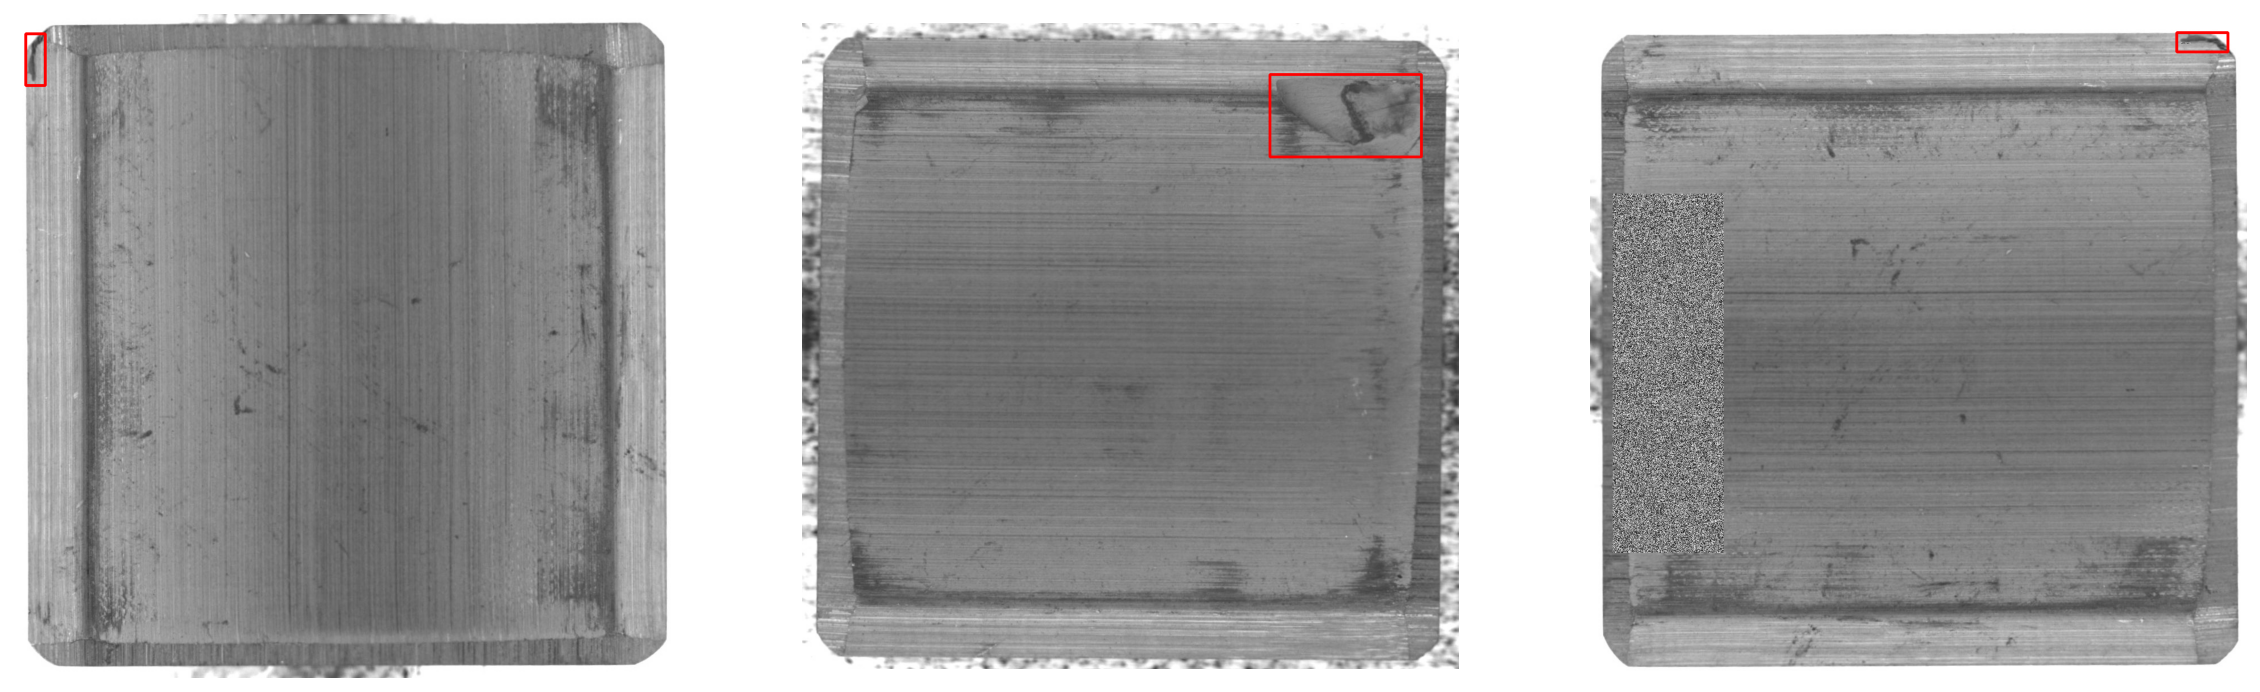

In [10]:
labels_dataset, image_names=read_files(image_directory,labels_directory)
plt.figure(1)
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(131)
im1=np.array(cv2.imread(image_directory+'/'+image_names[0]))
_, a, b, bbox_width, bbox_height=xml2dim(labels_dataset[0])#lbl, a, b, bbox_width, bbox_height
w = int(im1.shape[1])
h = int(im1.shape[0])
x1, y1 = np.round_((a-bbox_width/2)*w,0), np.round_((b-bbox_height/2)*h,0)
x2, y2 = np.round_((a+bbox_width/2)*w,0), np.round_((b+bbox_height/2)*h,0)
cv2.rectangle(im1, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=3)
plt.imshow(im1)
plt.axis('off');

plt.subplot(132)
im2=np.array(cv2.imread(image_directory+'/'+image_names[1]))
_, a, b, bbox_width, bbox_height=xml2dim(labels_dataset[1])#lbl, a, b, bbox_width, bbox_height
w = int(im2.shape[1])
h = int(im2.shape[0])
x1, y1 = np.round_((a-bbox_width/2)*w,0), np.round_((b-bbox_height/2)*h,0)
x2, y2 = np.round_((a+bbox_width/2)*w,0), np.round_((b+bbox_height/2)*h,0)
cv2.rectangle(im2, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=3)
plt.imshow(im2)
plt.axis('off');

plt.subplot(133)
im3=np.array(cv2.imread(image_directory+'/'+image_names[2]))
_, a, b, bbox_width, bbox_height=xml2dim(labels_dataset[2])#lbl, a, b, bbox_width, bbox_height
w = int(im3.shape[1])
h = int(im3.shape[0])
x1, y1 = np.round_((a-bbox_width/2)*w,0), np.round_((b-bbox_height/2)*h,0)
x2, y2 = np.round_((a+bbox_width/2)*w,0), np.round_((b+bbox_height/2)*h,0)
cv2.rectangle(im3, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=3)
plt.imshow(im3)
plt.axis('off');